# Deep Deterministic Policy Gradient (DDPG)
**Author:** [amifunny](https://github.com/amifunny)<br>
**Date created:** 2020/06/04<br>
**Last modified:** 2020/09/21<br>
**Updated:** JoRdI 2023/03/20<br>
Based on https://github.com/keras-team/keras-io/blob/master/examples/rl/ipynb/ddpg_pendulum.ipynb

## Introduction

**Deep Deterministic Policy Gradient (DDPG)** is a model-free off-policy algorithm for
learning continous actions.

It combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network).
It uses Experience Replay and slow-learning target networks from DQN, and it is based on
DPG,
which can operate over continuous action spaces.

This tutorial closely follow this paper -
[Continuous control with deep reinforcement learning](https://arxiv.org/pdf/1509.02971.pdf)

## Problem

We are trying to solve the classic **Inverted Pendulum** control problem.
In this setting, we can take only two actions: swing left or swing right.

What make this problem challenging for Q-Learning Algorithms is that actions
are **continuous** instead of being **discrete**. That is, instead of using two
discrete actions like `-1` or `+1`, we have to select from infinite actions
ranging from `-2` to `+2`.

## Quick theory

Just like the Actor-Critic method, we have two networks:

1. Actor - It proposes an action given a state.
2. Critic - It predicts if the action is good (positive value) or bad (negative value)
given a state and an action.

DDPG uses two more techniques not present in the original DQN:

**First, it uses two Target networks.**

**Why?** Because it add stability to training. In short, we are learning from estimated
targets and Target networks are updated slowly, hence keeping our estimated targets
stable.

Conceptually, this is like saying, "I have an idea of how to play this well,
I'm going to try it out for a bit until I find something better",
as opposed to saying "I'm going to re-learn how to play this entire game after every
move".
See this [StackOverflow answer](https://stackoverflow.com/a/54238556/13475679).

**Second, it uses Experience Replay.**

We store list of tuples `(state, action, reward, next_state)`, and instead of
learning only from recent experience, we learn from sampling all of our experience
accumulated so far.

This is an sketch of the algorithm as published in the original paper:

![Algorithm](https://i.imgur.com/mS6iGyJ.jpg)

In [1]:
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
os.mkdir("weights")

In [3]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

We use [OpenAIGym](http://gym.openai.com/docs) to create the environment.
We will use the `upper_bound` parameter to scale our actions later.

In [4]:
problem = "Pendulum-v1"
env = gym.make(problem, render_mode='rgb_array', new_step_api=True)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


To implement better exploration by the Actor network, we use noisy perturbations drawn from an [**Ornstein-Uhlenbeck process**](https://towardsdatascience.com/stochastic-processes-simulation-the-ornstein-uhlenbeck-process-e8bff820f3) for generating noise, as described in the paper. It samples noise from a correlated normal distribution.

In [5]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

This is how this stationary random process looks like

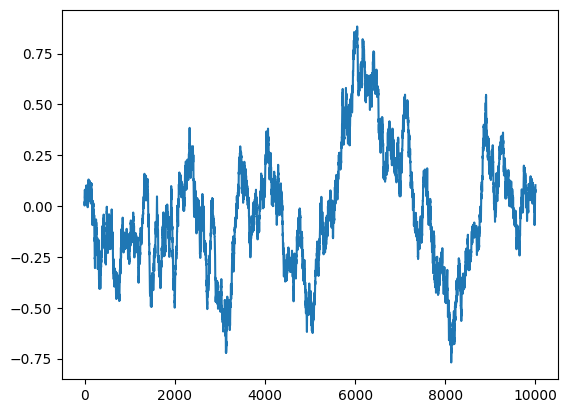

In [6]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
plt.plot([ou_noise() for _ in range(10000)]);

The following `Buffer` class implements Experience Replay (the buffer $R$).

- The `__init__` method initializes the state, action, reward and next_state buffers.
- The `record` method just saves an observation to the buffers. When the buffer is full it discards the first entries.
- The `update` method is in charge of updating the weights of the Actor $\mu(s|\theta^\mu)$ and Critic $Q(s,a|\theta^Q)$ models.
- The `learn` method is called after we have collected a new record. It:
  1. Randomly selects a batch of samples from the buffer (i.e., from $R$).
  2. Updates the weights of the Actor and Critic models.

**Critic loss** - Mean Squared Error of `y - Q(s,a)`
where `y` is the expected return as seen by the Target Critic network,
and `Q(s,a)` is action value predicted by the Critic network. `y` is a moving target
that the critic model tries to achieve; we make this target
stable by updating the Target model slowly.

**Actor loss** - This is computed using the mean of the value given by the Critic network
for the actions taken by the Actor network. We seek to maximize this quantity.
Hence we update the Actor network so that it produces actions that get
the maximum predicted value as seen by the Critic, for a given state.

In [7]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Train the critic network using the target actor and the target critic (see the sketch above)
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        # Train the actor network
        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # Compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)

Here we define the function in charge of update the Target models

In [8]:
# This update target parameters slowly based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

Here we define the Actor and Critic networks. These are basic Dense models
with `ReLU` activation.

Note: We need the initialization for last layer of the Actor to be between
`-0.003` and `0.003` as this prevents us from getting `1` or `-1` output values in
the initial stages, which would squash our gradients to zero,
as we use the `tanh` activation.

In [9]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)
    return model

`policy()` returns an action sampled from our Actor network plus some noise (using the Ornstein-Uhlenbeck process defined before) for exploration.

In [10]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise
    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_action)]

## Training hyperparameters

In [11]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

Now we implement our main training loop, and iterate over episodes.
We sample actions using `policy()` and train with `learn()` at each time step,
along with updating the Target networks at a rate `tau`.

In [12]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, terminated, truncated, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `terminated` or `truncated` are True
        if terminated or truncated:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)
    
    if (ep+1) % 10 == 0:
        print("Episode {:4d},  avg reward {:.4f}".format(ep+1, avg_reward))

    # Save model at an early stage for comparison
    if ep == 40:
        actor_model.save_weights("weights/pendulum_actor_%d.h5" % ep)
        critic_model.save_weights("weights/pendulum_critic_%d.h5" % ep)
        target_actor.save_weights("weights/pendulum_target_actor_%d.h5" % ep)
        target_critic.save_weights("weights/pendulum_target_critic_%d.h5" % ep)

Episode   10,  avg reward -1349.1694
Episode   20,  avg reward -1057.2647
Episode   30,  avg reward -770.3227
Episode   40,  avg reward -615.5270
Episode   50,  avg reward -344.5388
Episode   60,  avg reward -209.9138
Episode   70,  avg reward -204.3003
Episode   80,  avg reward -226.4400
Episode   90,  avg reward -205.8340
Episode  100,  avg reward -191.5977


In [13]:
# Save the weights
actor_model.save_weights("weights/pendulum_actor.h5")
critic_model.save_weights("weights/pendulum_critic.h5")

target_actor.save_weights("weights/pendulum_target_actor.h5")
target_critic.save_weights("weights/pendulum_target_critic.h5")

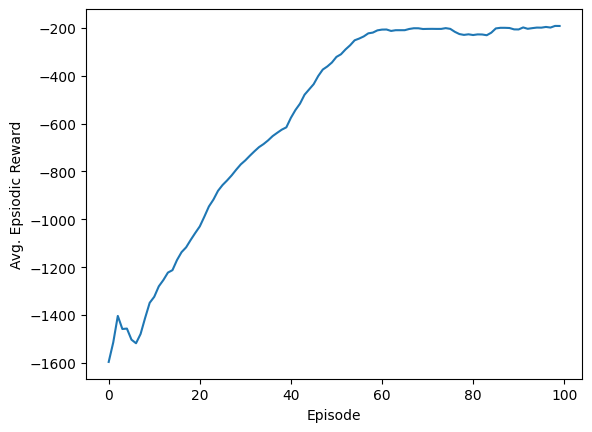

In [14]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [15]:
state = env.reset()
total_reward = 0
for n in range(300):
    action = actor_model(tf.expand_dims(state, 0))
    # action = target_actor(tf.expand_dims(state, 0))
    state, reward, terminated, truncated, info = env.step(action[0])
    total_reward += reward
    if terminated:
        print("Terminated")
        break
    if truncated:
        print("Truncated")
        break

imgs = env.render()
print("Episodes", n+1, "total reward", total_reward)

Truncated
Episodes 200 total reward -254.89769661463168


In [16]:
from PIL import Image, ImageDraw, ImageFont
from IPython import display

def show_animation(imgs):
    font = ImageFont.truetype("LiberationMono-Regular.ttf", size=14)
    frames = [Image.fromarray(im) for im in imgs]
    for n, frame in enumerate(frames):
        draw = ImageDraw.Draw(frame)
        draw.text((10, 10), 'Frame %d' % (n+1), fill=(0, 0, 0), font=font)
    animation = frames[0]
    animation.save("animation.gif", format="GIF", append_images=frames, save_all=True, duration=100)  # duration in ms
    # display.Image('animation.gif')

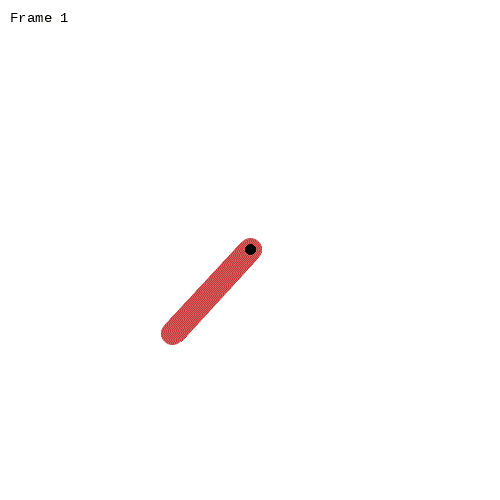

In [17]:
show_animation(imgs)
display.Image('animation.gif')

In [18]:
# Play with a the model in first stages of training
actor_model_40 = get_actor()
actor_model_40.load_weights("weights/pendulum_actor_40.h5")

state = env.reset()
total_reward = 0
for n in range(100):
    action = actor_model_40(tf.expand_dims(state, 0))
    state, reward, terminated, truncated, info = env.step(action[0])
    total_reward += reward
    if terminated:
        print("Terminated")
        break
    if truncated:
        print("Truncated")
        break

imgs = env.render()
print("Episodes", n+1, "total reward", total_reward)

Episodes 100 total reward -127.15217748170127


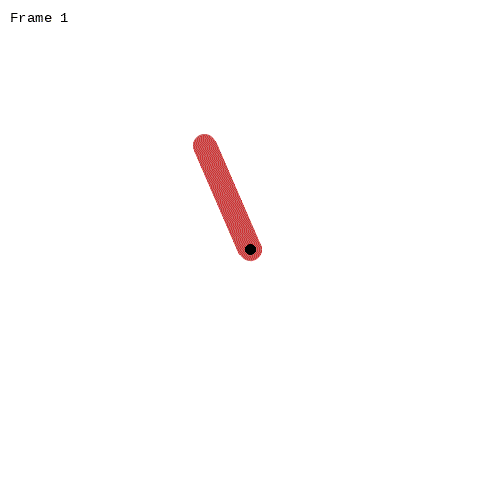

In [19]:
show_animation(imgs)
display.Image('animation.gif')

# Exercices

### Excercise 1: try to use noise from a Gaussian distribution instead of the Ornstein-Uhlenbeck process.

In [20]:
std_dev = 0.2
noise = np.random.normal(loc=np.zeros(1), scale=float(std_dev)*np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

In [22]:
# Modificamos la política por el formato del nuevo ruido

def policy_new(state, noise):
    sampled_actions = tf.squeeze(actor_model(state))
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise
    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_action)]


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy_new(tf_prev_state, noise)
        # Recieve state and reward from environment.
        state, reward, terminated, truncated, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `terminated` or `truncated` are True
        if terminated or truncated:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)
    
    if (ep+1) % 10 == 0:
        print("Episode {:4d},  avg reward {:.4f}".format(ep+1, avg_reward))

    # Save model at an early stage for comparison
    if ep == 40:
        actor_model.save_weights("weights/pendulum_actor_%d.h5" % ep)
        critic_model.save_weights("weights/pendulum_critic_%d.h5" % ep)
        target_actor.save_weights("weights/pendulum_target_actor_%d.h5" % ep)
        target_critic.save_weights("weights/pendulum_target_critic_%d.h5" % ep)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode   10,  avg reward -1402.2667
Episode   20,  avg reward -960.3928
Episode   30,  avg reward -685.4354
Episode   40,  avg reward -551.1062
Episode   50,  avg reward -235.1075
Episode   60,  avg reward -148.6859
Episode   70,  avg reward -153.7114
Episode   80,  avg reward -150.8113
Episode   90,  avg reward -157.4593
Episode  100,  avg reward -139.3210


In [24]:
# Save the weights
actor_model.save_weights("weights/pendulum_actor.h5")
critic_model.save_weights("weights/pendulum_critic.h5")

target_actor.save_weights("weights/pendulum_target_actor.h5")
target_critic.save_weights("weights/pendulum_target_critic.h5")

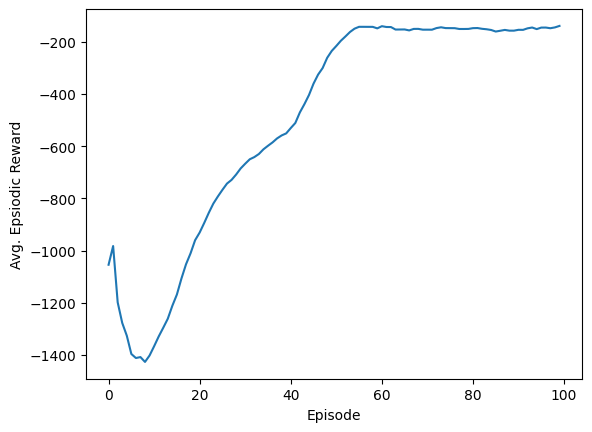

In [25]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [26]:
state = env.reset()
total_reward = 0
for n in range(300):
    action = actor_model(tf.expand_dims(state, 0))
    # action = target_actor(tf.expand_dims(state, 0))
    state, reward, terminated, truncated, info = env.step(action[0])
    total_reward += reward
    if terminated:
        print("Terminated")
        break
    if truncated:
        print("Truncated")
        break

imgs = env.render()
print("Episodes", n+1, "total reward", total_reward)

Truncated
Episodes 200 total reward -124.74825992144092


In [27]:
from PIL import Image, ImageDraw, ImageFont
from IPython import display

def show_animation(imgs):
    font = ImageFont.truetype("LiberationMono-Regular.ttf", size=14)
    frames = [Image.fromarray(im) for im in imgs]
    for n, frame in enumerate(frames):
        draw = ImageDraw.Draw(frame)
        draw.text((10, 10), 'Frame %d' % (n+1), fill=(0, 0, 0), font=font)
    animation = frames[0]
    animation.save("animation.gif", format="GIF", append_images=frames, save_all=True, duration=100)  # duration in ms
    # display.Image('animation.gif')

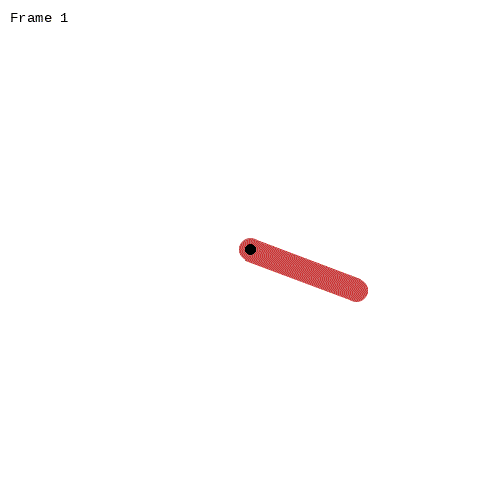

In [28]:
show_animation(imgs)
display.Image('animation.gif')

In [29]:
# Play with a the model in first stages of training
actor_model_40 = get_actor()
actor_model_40.load_weights("weights/pendulum_actor_40.h5")

state = env.reset()
total_reward = 0
for n in range(100):
    action = actor_model_40(tf.expand_dims(state, 0))
    state, reward, terminated, truncated, info = env.step(action[0])
    total_reward += reward
    if terminated:
        print("Terminated")
        break
    if truncated:
        print("Truncated")
        break

imgs = env.render()
print("Episodes", n+1, "total reward", total_reward)

Episodes 100 total reward -129.342716690697


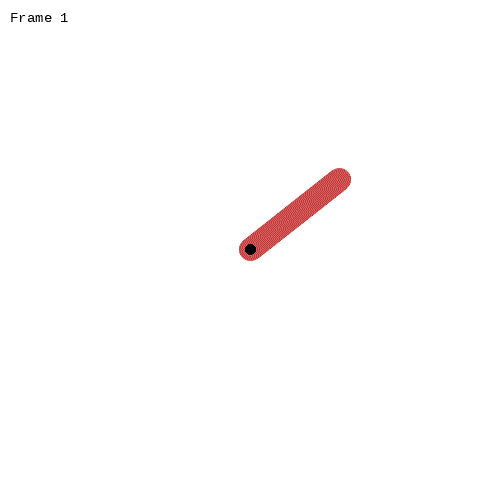

In [30]:
show_animation(imgs)
display.Image('animation.gif')

### Exercice 2: try with different learning rates, `tau` values and architectures for the Actor and Critic networks.

In [31]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.02
actor_lr = 0.01

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.05

buffer = Buffer(50000, 64)

Now we implement our main training loop, and iterate over episodes.
We sample actions using `policy()` and train with `learn()` at each time step,
along with updating the Target networks at a rate `tau`.

In [32]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, terminated, truncated, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `terminated` or `truncated` are True
        if terminated or truncated:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)
    
    if (ep+1) % 10 == 0:
        print("Episode {:4d},  avg reward {:.4f}".format(ep+1, avg_reward))

    # Save model at an early stage for comparison
    if ep == 40:
        actor_model.save_weights("weights/pendulum_actor_%d.h5" % ep)
        critic_model.save_weights("weights/pendulum_critic_%d.h5" % ep)
        target_actor.save_weights("weights/pendulum_target_actor_%d.h5" % ep)
        target_critic.save_weights("weights/pendulum_target_critic_%d.h5" % ep)

Episode   10,  avg reward -1262.6055
Episode   20,  avg reward -938.0237
Episode   30,  avg reward -823.7415
Episode   40,  avg reward -711.7263
Episode   50,  avg reward -441.9475
Episode   60,  avg reward -365.5230
Episode   70,  avg reward -281.7421
Episode   80,  avg reward -249.0089
Episode   90,  avg reward -244.9750
Episode  100,  avg reward -204.4988


In [40]:
# Save the weights
actor_model.save_weights("weights/pendulum_actor.h5")
critic_model.save_weights("weights/pendulum_critic.h5")

target_actor.save_weights("weights/pendulum_target_actor.h5")
target_critic.save_weights("weights/pendulum_target_critic.h5")

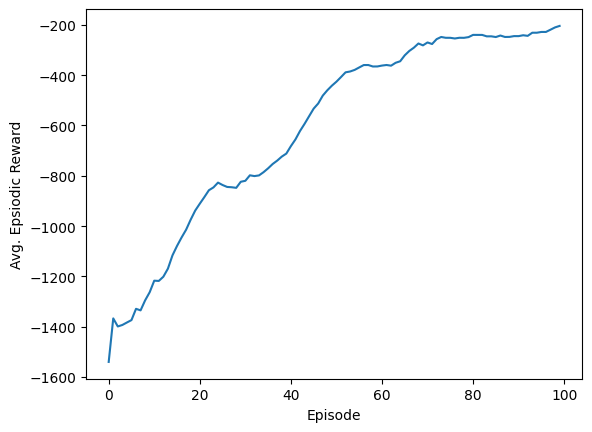

In [41]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [42]:
state = env.reset()
total_reward = 0
for n in range(300):
    action = actor_model(tf.expand_dims(state, 0))
    # action = target_actor(tf.expand_dims(state, 0))
    state, reward, terminated, truncated, info = env.step(action[0])
    total_reward += reward
    if terminated:
        print("Terminated")
        break
    if truncated:
        print("Truncated")
        break

imgs = env.render()
print("Episodes", n+1, "total reward", total_reward)

Truncated
Episodes 200 total reward -0.527991814287275


In [43]:
from PIL import Image, ImageDraw, ImageFont
from IPython import display

def show_animation(imgs):
    font = ImageFont.truetype("LiberationMono-Regular.ttf", size=14)
    frames = [Image.fromarray(im) for im in imgs]
    for n, frame in enumerate(frames):
        draw = ImageDraw.Draw(frame)
        draw.text((10, 10), 'Frame %d' % (n+1), fill=(0, 0, 0), font=font)
    animation = frames[0]
    animation.save("animation.gif", format="GIF", append_images=frames, save_all=True, duration=100)  # duration in ms
    # display.Image('animation.gif')

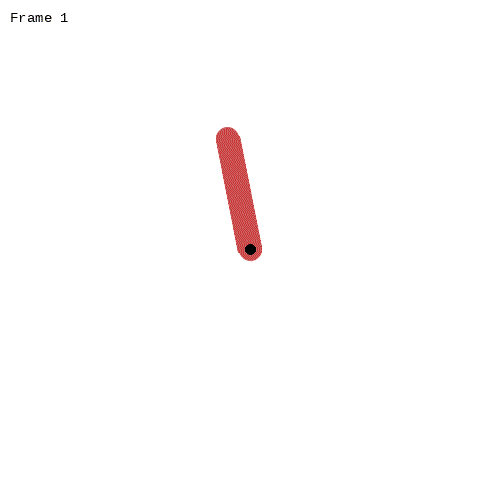

In [44]:
show_animation(imgs)
display.Image('animation.gif')

In [45]:
# Play with a the model in first stages of training
actor_model_40 = get_actor()
actor_model_40.load_weights("weights/pendulum_actor_40.h5")

state = env.reset()
total_reward = 0
for n in range(100):
    action = actor_model_40(tf.expand_dims(state, 0))
    state, reward, terminated, truncated, info = env.step(action[0])
    total_reward += reward
    if terminated:
        print("Terminated")
        break
    if truncated:
        print("Truncated")
        break

imgs = env.render()
print("Episodes", n+1, "total reward", total_reward)

Episodes 100 total reward -117.28203335073522


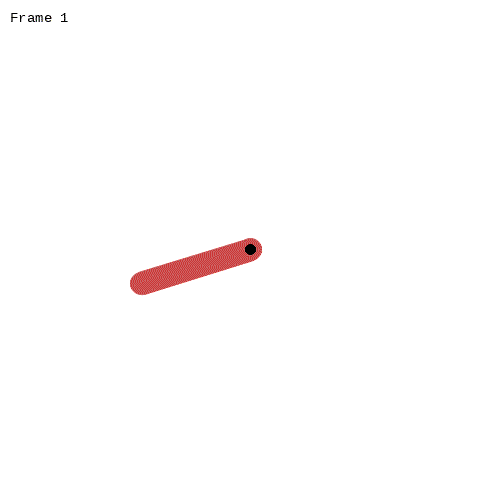

In [46]:
show_animation(imgs)
display.Image('animation.gif')

### Exercice 3: adapt the code to work with the [Lunar Lander](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) environment.

### **Super** Extra Excercice: modify the code to implement the [normalized adantage functions (NAF)](https://arxiv.org/abs/1603.00748) algorithm.